В задаче необходимо научиться определять, утонет ли посетитель Титаника или нет по наличию (не всегда хорошо заполненных) признаков.

train.csv — набор данных на основании которого будет строиться модель (обучающая выборка)<br>
test.csv — набор данных для проверки модели

Для каждого пассажира известны следующие признаки

PassengerId — идентификатор пассажира<br>
Survival — поле в котором указано спасся человек (1) или нет (0)<br>
Pclass — содержит социально-экономический статус (высокий, средний, низкий)<br>
Name — имя пассажира<br>
Sex — пол пассажира<br>
Age — возраст<br>
SibSp — содержит информацию о количестве родственников 2-го порядка (муж, жена, братья, сетры)<br>
Parch — содержит информацию о количестве родственников на борту 1-го порядка (мать, отец, дети)<br>
Ticket — номер билета<br>
Fare — цена билета<br>
Cabin — каюта<br>
Embarked — порт посадки (C — Cherbourg, Q — Queenstown, S — Southampton)<br>

Для начала с помощью Pandas посмотрим на данные

In [14]:
y_true = [1,1,0,1]
y_pred = [0.9, 0.4, 0.2, 0.1]
logloss = 0
from math import log
for i in range(4):
    logloss += y_true[i]*log(y_pred[i]) + (1 - y_true[i])*log(1 - y_pred[i])
    
-logloss/4

0.8868449729600592

In [15]:
from sklearn.metrics import log_loss
log_loss(y_true, y_pred)

0.8868449729600592

In [1]:
import pandas as pd
import os

titanic_data = '/data/share/text4/'

train = pd.read_csv(os.path.join(titanic_data,'train.csv'))
test = pd.read_csv(os.path.join(titanic_data,'test.csv'))

In [2]:
# сохраним исходную выборку ещё раз
train_raw = pd.read_csv(os.path.join(titanic_data,'train.csv'))
test_raw = pd.read_csv(os.path.join(titanic_data,'test.csv'))

In [3]:
def make_features(features):
    features.Age[features.Age.isnull()] = features.Age.median()
    features.Fare[features.Fare.isnull()] = features.Fare.median() #заполняем пустые значения средней ценой билета
    features = pd.get_dummies(features, columns=['Sex', 'Embarked'])
    features = features.drop(['Name','Ticket','Cabin','PassengerId'],axis=1)
    return features

In [4]:
train = make_features(train)
test = make_features(test)

/opt/anaconda/envs/bd9/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/anaconda/envs/bd9/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
target_col = 'Survived'
features = list(train.columns)
features.remove('Sex_female')
features.remove(target_col)

In [19]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Быстрый старт. Попробуем взять быка за рога

Помним, что модели машинного обучения принимают на вход только числа. Удалим всё, что не число.

In [17]:
y = train['Survived']

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [34]:
train_small.describe()

,PassengerId,Survived,Pclass,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,8.000000,6.000000,512.329200


In [71]:
train_small = train.drop(columns=['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Survived'])

In [72]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_small, y, test_size=0.2)

In [73]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
predict = model.predict(X_test)

In [41]:
predict

array([[0.41746116, 0.58253884],
       [0.69526598, 0.30473402],
       [0.3619589 , 0.6380411 ],
       [0.75744848, 0.24255152],
       [0.74914465, 0.25085535],
       [0.70010801, 0.29989199],
       [0.60882384, 0.39117616],
       [0.73191704, 0.26808296],
       [0.74889332, 0.25110668],
       [0.35902935, 0.64097065],
       [0.39998046, 0.60001954],
       [0.75329234, 0.24670766],
       [0.75083405, 0.24916595],
       [0.4242836 , 0.5757164 ],
       [0.75252829, 0.24747171],
       [0.02898858, 0.97101142],
       [0.39809577, 0.60190423],
       [0.39504316, 0.60495684],
       [0.26954392, 0.73045608],
       [0.37245738, 0.62754262],
       [0.65523577, 0.34476423],
       [0.75920581, 0.24079419],
       [0.62394625, 0.37605375],
       [0.60726983, 0.39273017],
       [0.7432893 , 0.2567107 ],
       [0.75178266, 0.24821734],
       [0.75056315, 0.24943685],
       [0.10796105, 0.89203895],
       [0.61221727, 0.38778273],
       [0.02289707, 0.97710293],
       [0.

In [74]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predict)

0.6927374301675978

In [76]:
train_small.columns

Index(['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

In [75]:
model.coef_

array([[ 2.42584491e-04, -7.55911569e-01, -3.70052172e-02,
        -2.31158952e-01,  2.57523344e-01,  7.92641800e-03]])

0.7061141304347825


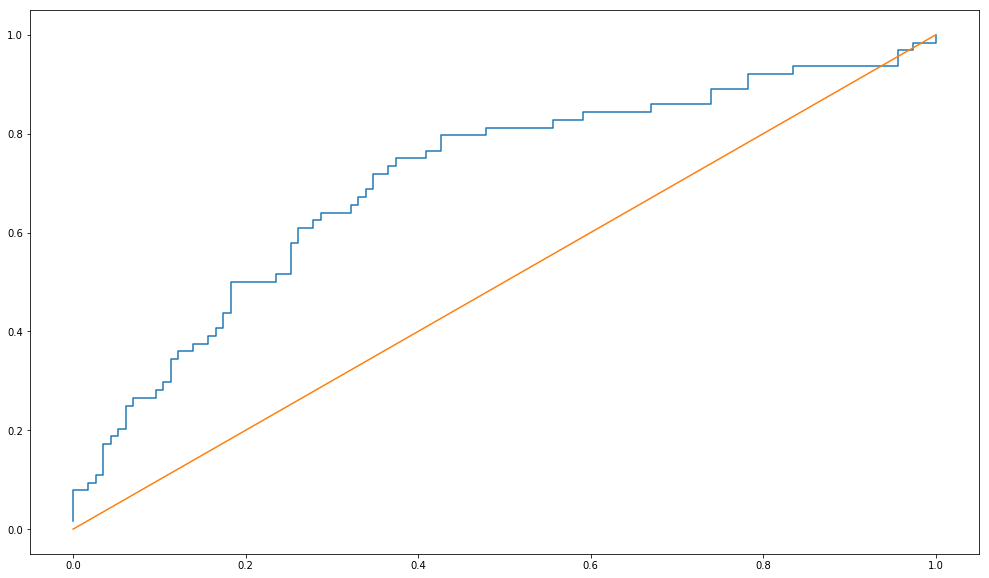

In [45]:
from sklearn.metrics import roc_curve, roc_auc_score
from random import random
from matplotlib import pyplot as plt
fpr, tpr, thresholds = roc_curve(y_test, predict[:,1])

plt.figure(figsize=(17,10))
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1])
print(roc_auc_score(y_test, predict[:,1]))

Начнём с самого простого - baseline-модели. Например, предположим, что спаслись богатеи из 1 и 2 класса


In [50]:
predict = []
for i in range(len(train)):
    predict = train['Sex'].apply(lambda x: int(x == 'female'))
    #predict = train['Pclass'].apply(lambda x: int(x < 3))
#predict

In [52]:
accuracy_score(y, predict)

0.7867564534231201

0.7668727830505226


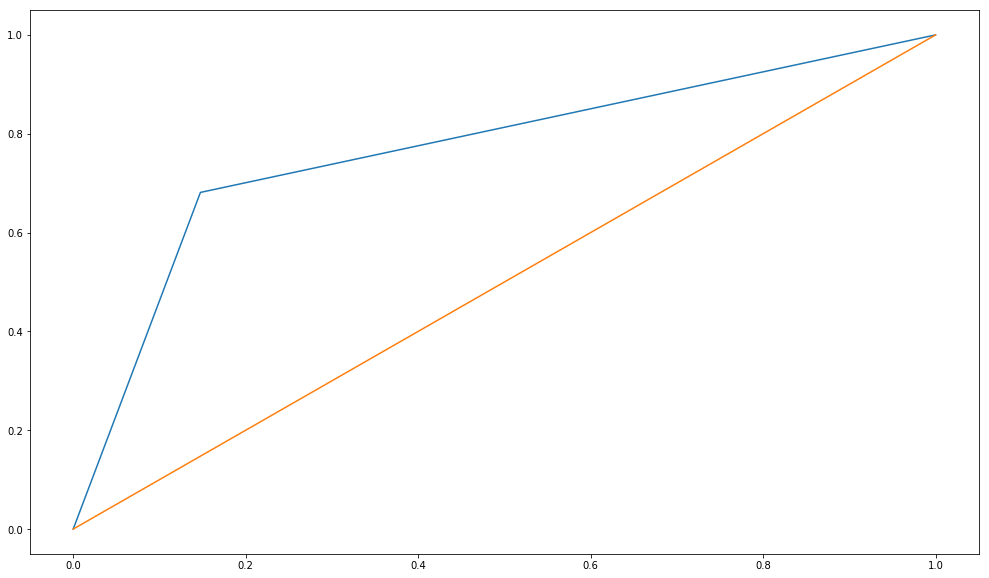

In [51]:
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot as plt
fpr, tpr, thresholds = roc_curve(y, predict)

plt.figure(figsize=(17,10))
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1])
print(roc_auc_score(y, predict))

Посмотрим теперь, все ли хорошо с данными, есть ли в них пропуски. Очень полезно для этого использовать info() и describe()

In [64]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       891 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [ ]:
train.describe()

In [ ]:
train.groupby('Sex').median()

Видим, что номера кают заполнены очень плохо, возраст можно попытаться как-то восстановить: есть 2 варианта - заполнить медианным значением или же натренировать классификатор по другим признакам. Поступим простым путем - заполним медианным значением

In [58]:
train.Age[train.Age.isnull()]

Series([], Name: Age, dtype: float64)

In [56]:
train[train['Sex'] == 'female'].Age.median()

27.0

In [57]:
train.Age = train.Age.fillna(train.Age.median())

Остался еще порт посадки - там всего 2 значения не заполнены. Давайте присвоим эти пассажирам порт в котором село больше всего людей:

In [60]:
MaxPortEmbarked = train.groupby('Embarked').count()['PassengerId']
MaxPortEmbarked

Embarked
C    168
Q     77
S    644
Name: PassengerId, dtype: int64

In [62]:
MaxPassEmbarked = train.groupby('Embarked').count()['PassengerId']
train.Embarked[train.Embarked.isnull()] = MaxPassEmbarked[MaxPassEmbarked == MaxPassEmbarked.max()].index[0]

/opt/anaconda/envs/bd9/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [63]:
train.Embarked[train.Embarked.isnull()]

Series([], Name: Embarked, dtype: object)

Теперь посмотрим на оставшиеся данные. Важно понимать, что ненужные признаки нужно отбрасывать - т.к. они добавляют шум. <br>
У нас остались: Имя (из него можно попробовать вытащить пол - упражнение на дом), Номер билета (тут ради интереса можно проверить на какую-нибудь четность, например), Номер каюты (тоже в нумерологию не верим)    

In [83]:
train_cat = train_cat.drop(['PassengerId','Name','Ticket','Cabin'], axis=1)

In [85]:
train_cat = train_cat.drop(['Sex_female'], axis=1)

Теперь посмотрим на то, что осталось

Что делать с категориальными переменным? Их нужно закодировать

In [81]:
train_cat = pd.get_dummies(train, columns=['Sex', 'Embarked'])

In [86]:
train_cat.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,1,0,0,1
1,1,1,38.0,1,0,71.2833,0,1,0,0
2,1,3,26.0,0,0,7.9250,0,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,0,1


In [99]:
train_cat.corr()['Pclass']

Survived     -0.338481
Pclass        1.000000
Age          -0.339898
SibSp         0.083081
Parch         0.018443
Fare         -0.549500
Sex_male      0.131900
Embarked_C   -0.243292
Embarked_Q    0.221009
Embarked_S    0.074053
Name: Pclass, dtype: float64

In [101]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(train_cat.drop(columns=['Survived']), train_cat['Survived'])
predict = model.predict_proba(train_cat.drop(columns=['Survived']))

In [90]:
accuracy_score(y, predict)

0.8024691358024691

0.8572284536477807


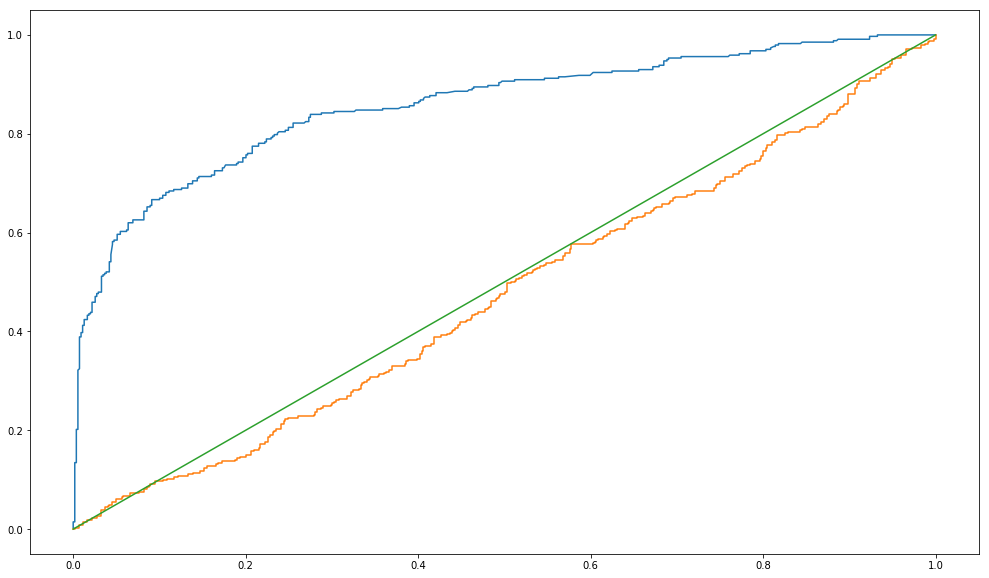

In [102]:
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot as plt
from random import random
fpr, tpr, thresholds = roc_curve(train_cat['Survived'], predict[:,1])

plt.figure(figsize=(17,10))
plt.plot(fpr, tpr)
fpr, tpr, thresholds = roc_curve(train_cat['Survived'], [random() for _ in range(len(train_cat))])
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1])
print(roc_auc_score(train_cat['Survived'], predict[:,1]))

Обучались и проверяли на одном и том же. Исправим это.

In [96]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_cat.drop(columns=['Survived']), train_cat['Survived'],
                                                    test_size = 0.2)

In [97]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
predict = model.predict(X_test)

In [98]:
accuracy_score(y_test, predict)

0.7653631284916201

0.8750649013499482


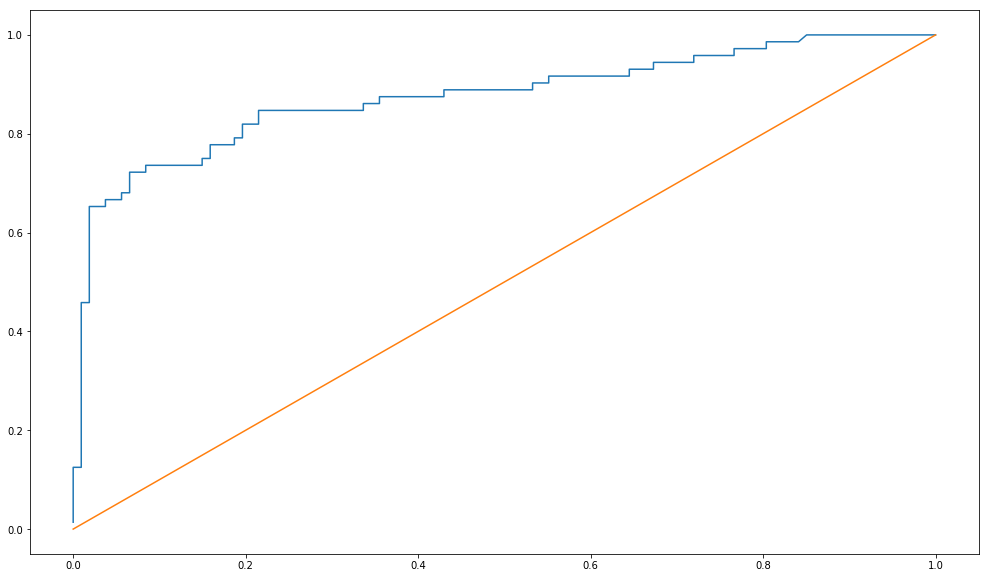

In [93]:
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot as plt
fpr, tpr, thresholds = roc_curve(y_test, predict[:,1])

plt.figure(figsize=(17,10))
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1])
print(roc_auc_score(y_test, predict[:,1]))

А теперь кросс-валидацию попробуем

In [105]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
cross_val_score(model, X_train, y_train, cv=50, scoring =  make_scorer(accuracy_score))

array([0.86666667, 0.73333333, 0.73333333, 0.86666667, 0.8       ,
       0.8       , 0.93333333, 0.86666667, 0.93333333, 0.93333333,
       0.8       , 0.93333333, 0.86666667, 0.8       , 0.8       ,
       0.8       , 0.73333333, 0.66666667, 0.8       , 0.8       ,
       0.6       , 0.8       , 0.46666667, 0.73333333, 0.73333333,
       0.73333333, 0.86666667, 0.71428571, 0.78571429, 1.        ,
       0.78571429, 0.85714286, 0.71428571, 0.85714286, 1.        ,
       0.69230769, 0.76923077, 0.84615385, 0.69230769, 0.61538462,
       0.76923077, 0.69230769, 0.76923077, 0.92307692, 1.        ,
       0.69230769, 0.92307692, 0.76923077, 0.84615385, 0.84615385])

In [ ]:
X_train.head()

Проверим счастливого пассажира 666

In [ ]:
passenger_666 = make_features(train[train['PassengerId'] == 666])
passenger_666['Embarked_C'] = 0
passenger_666['Embarked_Q'] = 0
passenger_666 = passenger_666[['Survived','Pclass','Age','SibSp','Parch','Fare','Sex_male','Embarked_C','Embarked_Q','Embarked_S']]
passenger_666.iloc[0,1:]

In [ ]:
def my_logreg(feat, coef, q):
    res = 0
    mult = list(zip(feat, coef))
    for el in mult:
        res+=el[0]*el[1]
    res+=q
    from math import exp
    
    return 1/(1+exp(-res))

In [ ]:
model.coef_

In [ ]:
passenger_666.iloc[0,1:].values

In [ ]:
my_logreg(passenger_666.iloc[0,1:].values, model.coef_[0], model.intercept_)

In [ ]:
model.predict_proba([passenger_666.iloc[0,1:].values])

Теперь, тоже самое нам нужно сделать с test.csv - удалить те же столбцы и сделать те же преобразования. На практике лучше сразу писать для этого отдельную функцию

In [3]:
def make_features(features):
    features.Age[features.Age.isnull()] = features.Age.median()
    features.Fare[features.Fare.isnull()] = features.Fare.median() #заполняем пустые значения средней ценой билета
    features = pd.get_dummies(features, columns=['Sex', 'Embarked'])
    features = features.drop(['Name','Ticket','Cabin','PassengerId'],axis=1)
    return features

In [ ]:
test.info()

In [5]:
from sklearn.model_selection import train_test_split

In [4]:
train = make_features(train)
test = make_features(test)
train.head()

/opt/anaconda/envs/bd9/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/anaconda/envs/bd9/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1


In [5]:
target_col = 'Survived'
features = list(train.columns)
features.remove('Sex_female')
features.remove(target_col)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(train[features], train[target_col], test_size=0.2)

NameError: name 'train_test_split' is not defined

In [ ]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test)

In [ ]:
train_target = train.Survived
train_features = train.drop(['Survived'], axis=1) #из исходных данных убираем Id пассажира и флаг спасся он или нет

In [ ]:
train_features.info()

Можно предположить, что чем выше социальный статус, тем больше вероятность спасения. Давайте посмотрим, действительно ли это так. Для этого построим сводную. 

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

train.pivot_table('PassengerId', 'Pclass', 'Survived', 'count').plot(kind='bar')

Теперь посмотрим, как влияет кол-во родственников на целевую переменную. Для этого построим также сводные:

In [ ]:
fig, axes = plt.subplots(ncols=2)
train.pivot_table('PassengerId', ['SibSp'], 'Survived', 'count').plot(ax=axes[0], title='SibSp')
train.pivot_table('PassengerId', ['Parch'], 'Survived', 'count').plot(ax=axes[1], title='Parch')

Все, 80% работы мы сделали: теперь мы имеем матрицу обьект-признак, которую можно "скармливать" на вход различным алгоритмам машинного обучения<br>
Будем пробовать SVM, KNeighbors, RandomForest, log-regression

In [6]:
from sklearn import cross_validation, svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import pylab as pl

/opt/anaconda/envs/bd9/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Для удобства (тут кому как нравится, если в голове все держите - можно не делать) выделим отдельно целевую переменную.

In [ ]:



kfold = 5 #количество подвыборок для валидации
itog_val = {} #список для записи результатов кросс валидации разных алгоритмов

# KNN

In [72]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train[features], train[target_col],
                                                    test_size = 0.2)

In [73]:
model_knc = KNeighborsClassifier(n_neighbors = 18) #в параметре передаем кол-во соседей
model_knc.fit(X_train, y_train)
predict = model_knc.predict_proba(X_test)

In [74]:
X_test.values[0]

array([ 3.    , 28.    ,  0.    ,  2.    , 15.2458,  0.    ,  1.    ,
        0.    ,  0.    ])

In [76]:
model_knc.kneighbors([X_test.values[0]])

(array([[1.        , 1.73205081, 1.73205081, 2.17149203, 2.37068687,
         2.45730292, 2.64976558, 2.65793484, 2.65793484, 2.65793484,
         2.65793484, 2.74885752, 2.76163549, 2.78022619, 2.78022619,
         2.81309774, 2.82482878, 2.83982704]]),
 array([[311,  23,  96,  29, 258, 471, 200, 395, 312, 509, 528, 655, 177,
         542, 138,  42,  61, 162]]))

In [77]:
X_train.values[311]

array([ 3.    , 29.    ,  0.    ,  2.    , 15.2458,  0.    ,  1.    ,
        0.    ,  0.    ])

0.7207489339019189


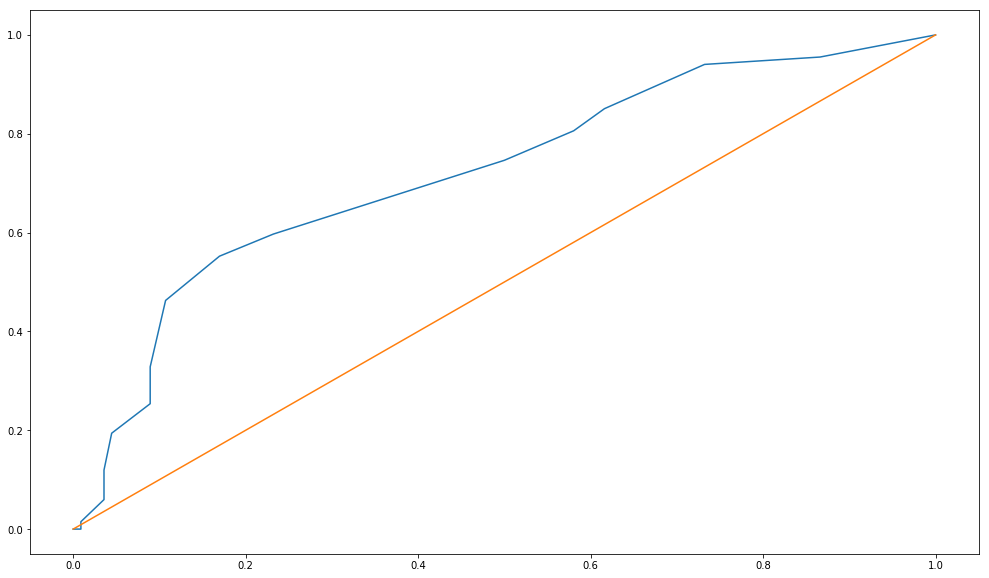

In [64]:
from sklearn.metrics import roc_curve, roc_auc_score
from random import random
from matplotlib import pyplot as plt
fpr, tpr, thresholds = roc_curve(y_test, predict[:,1])

plt.figure(figsize=(17,10))
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1])
print(roc_auc_score(y_test, predict[:,1]))

In [16]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, model_knc.predict(X_test))

0.8268156424581006

Масштаб признаков сильно влияет на вычисление метрики. Поэтому нужно нормализовать признаки.

In [79]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
model_knc = KNeighborsClassifier(n_neighbors = 18, p=1) #в параметре передаем кол-во соседей
model_knc.fit(scaler.fit_transform(X_train), y_train)
predict = model_knc.predict_proba(scaler.transform(X_test))


In [80]:
accuracy_score(y_test, model_knc.predict(scaler.transform(X_test)))

0.7988826815642458

0.837489943684634


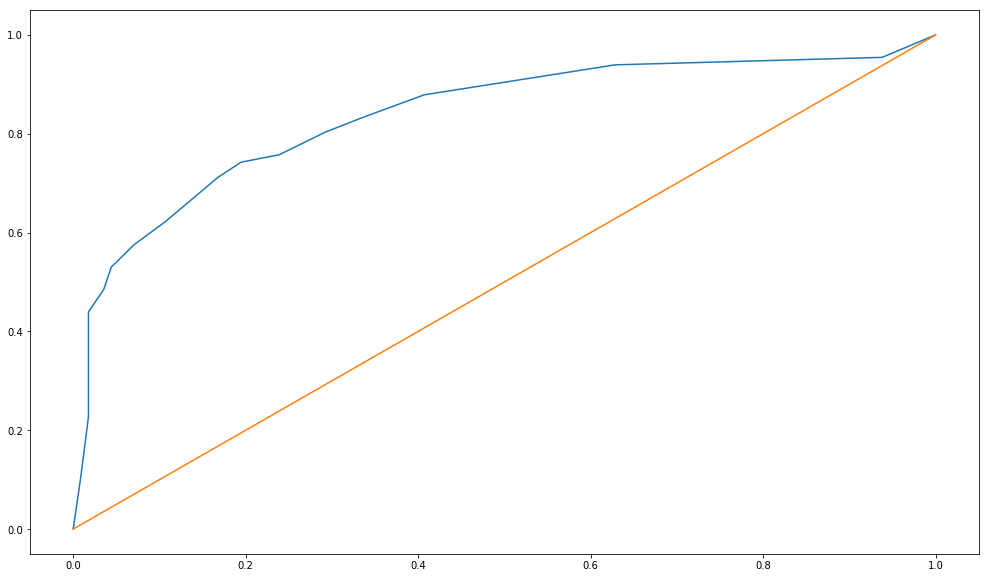

In [81]:
from sklearn.metrics import roc_curve, roc_auc_score
from random import random
from matplotlib import pyplot as plt
fpr, tpr, thresholds = roc_curve(y_test, predict[:,1])

plt.figure(figsize=(17,10))
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1])
print(roc_auc_score(y_test, predict[:,1]))

# SVM

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train[features], train[target_col],
                                                    test_size = 0.2)

In [58]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
model_svc = svm.SVC(probability=True, kernel = 'poly', degree=2) #по умолчанию kernel='rbf'
model_svc.fit(scaler.fit_transform(X_train), y_train)
predict = model_svc.predict_proba(scaler.transform(X_test))


In [8]:
%%time
model_svc = svm.SVC(probability=True) #по умолчанию kernel='rbf'
model_svc.fit(X_train, y_train)
predict = model_svc.predict_proba(X_test)

CPU times: user 184 ms, sys: 0 ns, total: 184 ms
Wall time: 182 ms


In [9]:
model_svc.support_

array([  2,   3,   6,  10,  12,  20,  23,  25,  26,  27,  28,  30,  36,
        38,  41,  48,  49,  51,  52,  53,  54,  55,  61,  66,  68,  69,
        70,  74,  76,  77,  84,  86,  89,  90,  91,  92,  93,  96,  99,
       102, 103, 105, 107, 109, 110, 114, 120, 121, 122, 123, 124, 128,
       129, 131, 132, 135, 137, 141, 143, 144, 145, 146, 147, 149, 155,
       157, 161, 163, 173, 176, 177, 178, 179, 180, 185, 186, 190, 191,
       192, 193, 194, 197, 199, 201, 202, 204, 205, 208, 209, 212, 213,
       216, 217, 219, 222, 227, 229, 231, 232, 234, 237, 238, 242, 246,
       247, 252, 254, 255, 256, 260, 261, 262, 265, 269, 270, 278, 279,
       281, 282, 287, 288, 295, 298, 299, 300, 301, 306, 309, 310, 319,
       322, 325, 330, 331, 332, 337, 338, 339, 340, 344, 345, 347, 349,
       352, 356, 358, 359, 364, 365, 366, 371, 375, 376, 378, 383, 391,
       392, 396, 399, 400, 401, 402, 403, 404, 406, 409, 410, 411, 412,
       413, 414, 415, 416, 417, 419, 421, 423, 424, 428, 431, 43

In [59]:
model_svc.support_

array([  1,   7,  12,  14,  17,  21,  22,  39,  40,  45,  52,  53,  60,
        61,  66,  67,  68,  74,  76,  77,  82,  88,  90,  91,  93,  96,
        98, 100, 103, 104, 114, 116, 118, 121, 126, 132, 142, 144, 148,
       154, 157, 158, 165, 167, 168, 169, 173, 174, 177, 182, 186, 187,
       188, 189, 200, 201, 203, 204, 212, 215, 217, 218, 220, 228, 230,
       238, 245, 249, 253, 254, 257, 264, 265, 270, 271, 272, 274, 277,
       279, 280, 282, 283, 288, 291, 293, 296, 298, 303, 305, 306, 309,
       314, 315, 316, 317, 322, 323, 324, 325, 328, 329, 332, 334, 336,
       337, 339, 341, 343, 345, 350, 352, 353, 358, 362, 375, 376, 381,
       386, 390, 398, 399, 407, 408, 410, 412, 413, 414, 419, 420, 421,
       430, 431, 432, 433, 435, 436, 439, 442, 447, 448, 450, 453, 454,
       458, 460, 461, 474, 476, 477, 479, 481, 491, 497, 507, 508, 512,
       513, 514, 516, 517, 521, 522, 523, 527, 528, 537, 538, 539, 544,
       550, 554, 555, 559, 568, 572, 580, 582, 585, 586, 591, 59

In [42]:
y_train.values[430]

0

0.8306474020561266


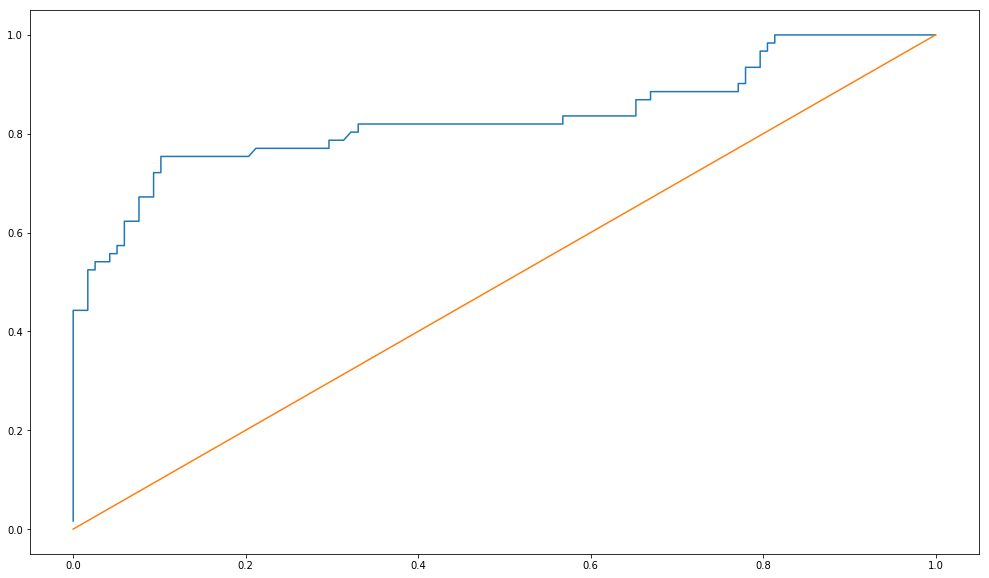

In [60]:
from sklearn.metrics import roc_curve, roc_auc_score
from random import random
from matplotlib import pyplot as plt
fpr, tpr, thresholds = roc_curve(y_test, predict[:,1])

plt.figure(figsize=(17,10))
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1])
print(roc_auc_score(y_test, predict[:,1]))

In [62]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, model_svc.predict(X_test))

0.8156424581005587

# Решающее дерево

In [8]:
from sklearn.tree import DecisionTreeClassifier

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train[features], train[target_col],
                                                    test_size = 0.2)

In [44]:
%%time
model_tree = DecisionTreeClassifier(max_depth=10)
model_tree.fit(X_train[features], y_train)
predict = model_tree.predict_proba(X_test)

CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 6.3 ms


0.8244269722814499


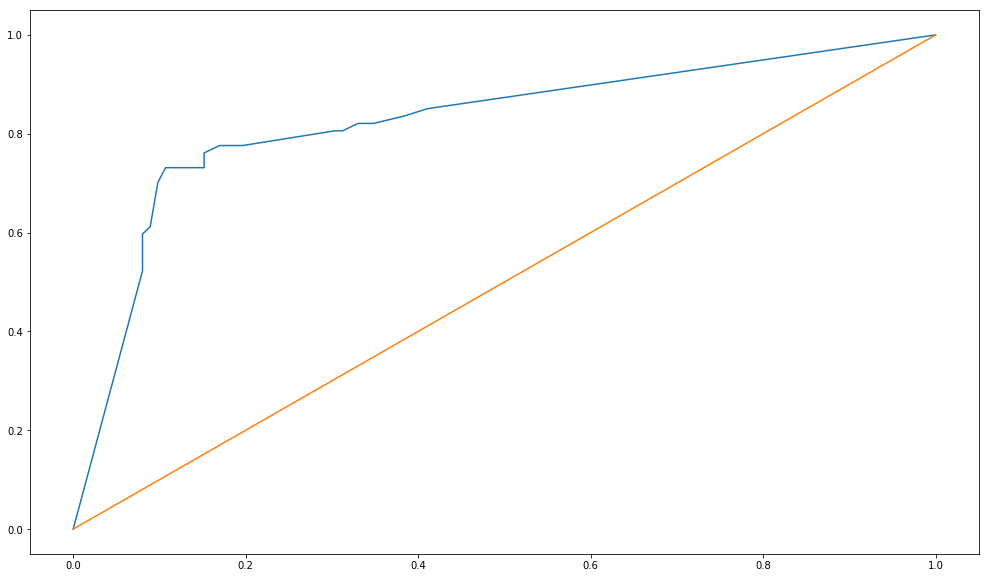

In [45]:
from sklearn.metrics import roc_curve, roc_auc_score
from random import random
from matplotlib import pyplot as plt
fpr, tpr, thresholds = roc_curve(y_test, predict[:,1])

plt.figure(figsize=(17,10))
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1])
print(roc_auc_score(y_test, predict[:,1]))

In [37]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, model_tree.predict(X_test))

0.8044692737430168

In [16]:
y_train.sum()

275

Визуализируем решающее дерево

In [21]:
from sklearn.tree import export_graphviz

In [22]:
!rm -rf tree.png
!rm -rf tree.dot
export_graphviz(model_tree, out_file='tree.dot', feature_names=features, filled=True)
!dot -Tpng tree.dot -o tree.png

<img src="tree.png">

# Random Forest

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train[features], train[target_col],
                                                    test_size = 0.2)

In [59]:
%%time
from sklearn.ensemble import RandomForestClassifier

model_rfc = RandomForestClassifier(n_estimators = 10, max_depth = 10, max_features=4)
model_rfc.fit(X_train, y_train)
predict = model_rfc.predict_proba(X_test)

CPU times: user 12 ms, sys: 8 ms, total: 20 ms
Wall time: 17.2 ms


In [55]:
model_rfc.feature_importances_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1310201806, splitter='best')

0.8798640724946695


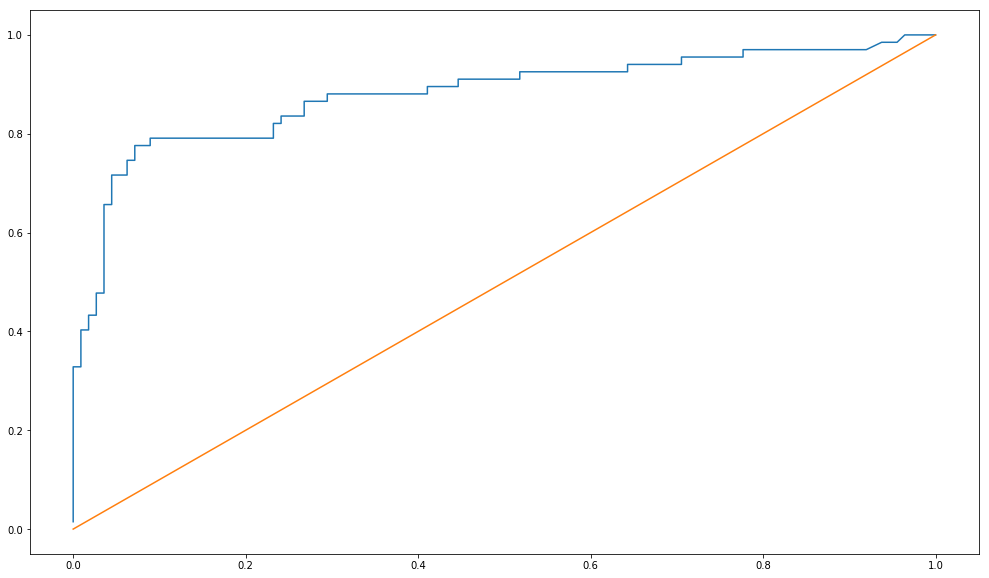

In [53]:
from sklearn.metrics import roc_curve, roc_auc_score
from random import random
from matplotlib import pyplot as plt
fpr, tpr, thresholds = roc_curve(y_test, predict[:,1])

plt.figure(figsize=(17,10))
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1])
print(roc_auc_score(y_test, predict[:,1]))

In [60]:
pd.DataFrame(list(zip(train[features].columns,model_rfc.feature_importances_)))

,0,1
0,Pclass,0.096607
1,Age,0.218500
2,SibSp,0.056829
3,Parch,0.033101
4,Fare,0.240066
5,Sex_male,0.317704
6,Embarked_C,0.016907
7,Embarked_Q,0.004848
8,Embarked_S,0.015439


In [71]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, model_rfc.predict(X_test))

0.8268156424581006

# Все модели вместе

In [97]:
model_rfc = RandomForestClassifier(n_estimators = 70) #в параметре передаем кол-во деревьев
model_knc = KNeighborsClassifier(n_neighbors = 18) #в параметре передаем кол-во соседей
model_lr = LogisticRegression(penalty='l1', tol=0.01) 
model_svc = svm.SVC(probability=True) #по умолчанию kernek='rbf'

Делаем скользящий контроль

In [98]:
scores = cross_validation.cross_val_score(model_rfc, train_features, train_target, cv = kfold)
itog_val['RandomForestClassifier'] = scores.mean()
scores = cross_validation.cross_val_score(model_knc, train_features, train_target, cv = kfold)
itog_val['KNeighborsClassifier'] = scores.mean()
scores = cross_validation.cross_val_score(model_lr, train_features, train_target, cv = kfold)
itog_val['LogisticRegression'] = scores.mean()
scores = cross_validation.cross_val_score(model_svc, train_features, train_target, cv = kfold)
itog_val['SVC'] = scores.mean()

NameError: name 'train_features' is not defined

In [ ]:
model_lr.score

In [ ]:
pd.DataFrame.from_dict(data = itog_val, orient='index').plot(kind='bar', legend=False)

Для построения ROC-кривых нам надо руками (с помощью функции train_test_split модуля cross_validation) делить на обучающую и проверочную выборки<br>
На выходе получим:<br>
новый обучающий массив признаков<br>
проверочный массив признаков<br>
новый массив целевой переменной<br>
проверочный массив целевой переменной

In [ ]:
ROCtrainTRN, ROCtestTRN, ROCtrainTRG, ROCtestTRG = cross_validation.train_test_split(train_features, train_target, test_size=0.25) 

In [ ]:
pl.clf()
plt.figure(figsize=(8,6))
#SVC
model_svc.probability = True
probas = model_svc.fit(ROCtrainTRN, ROCtrainTRG).predict_proba(ROCtestTRN)
fpr, tpr, thresholds = roc_curve(ROCtestTRG, probas[:, 1])
roc_auc  = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('SVC', roc_auc))
#RandomForestClassifier
probas = model_rfc.fit(ROCtrainTRN, ROCtrainTRG).predict_proba(ROCtestTRN)
fpr, tpr, thresholds = roc_curve(ROCtestTRG, probas[:, 1])
roc_auc  = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('RandonForest',roc_auc))
#KNeighborsClassifier
probas = model_knc.fit(ROCtrainTRN, ROCtrainTRG).predict_proba(ROCtestTRN)
fpr, tpr, thresholds = roc_curve(ROCtestTRG, probas[:, 1])
roc_auc  = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('KNeighborsClassifier',roc_auc))
#LogisticRegression
probas = model_lr.fit(ROCtrainTRN, ROCtrainTRG).predict_proba(ROCtestTRN)
fpr, tpr, thresholds = roc_curve(ROCtestTRG, probas[:, 1])
roc_auc  = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('LogisticRegression',roc_auc))
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.legend(loc=0, fontsize='small')
pl.show()

Чем выше лежит ROC-кривая - тем лучше - видим, что тут тоже RandomForest работает очень хорошо - оставляем его в качестве классификатора

Все, осталось вызвать predict для каждого обьекта из тестовой выборки и засабмитить результат

# Бустинг

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train[features], train['Survived'],
                                                    test_size = 0.2)

In [31]:
from xgboost import XGBClassifier
param = {'max_depth': 5,  'silent': 1, 'objective': 'binary:logistic',
        'colsample_bytree': 0.7, 'subsample':0.7, 'min_child_weight':5 }
param['nthread'] = 4
param['eval_metric'] = 'error'
param['n_estimators'] = 10
param['learning_rate'] = 0.2
model_xgb = XGBClassifier(**param)
model_xgb.fit(X_train, y_train)
predict = model_xgb.predict_proba(X_test)

0.881063432835821


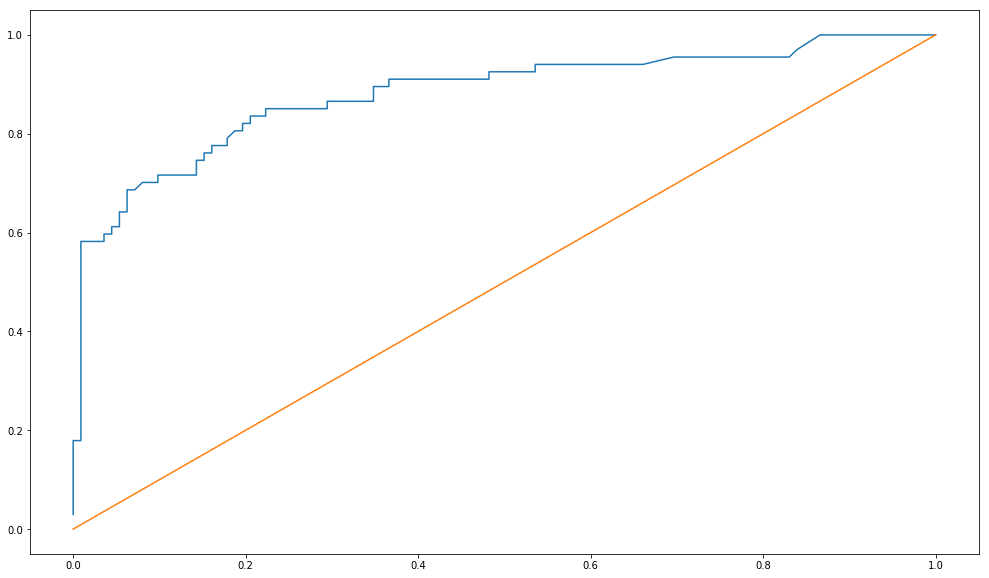

In [32]:
from sklearn.metrics import roc_curve, roc_auc_score
from random import random
from matplotlib import pyplot as plt
fpr, tpr, thresholds = roc_curve(y_test, predict[:,1])

plt.figure(figsize=(17,10))
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1])
print(roc_auc_score(y_test, predict[:,1]))

In [33]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, model_xgb.predict(X_test))

/opt/anaconda/envs/bd9/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8268156424581006

Обучим заново логистическую регрессию на всех фичах

In [ ]:
model_lr.fit(train_features, train_target)

Посмотрим какие фичи какой вклад вносят в модель логистической регрессии

In [ ]:
import numpy
for idx in numpy.argsort(model_lr.coef_)[0][:10]: # последние 10 с минимальным коэфициентом
    print '{}, importance = {:.5f}'.format(train_features.columns[idx], model_lr.coef_[0][idx])

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np

x1 = ['Bangalore','Bangalore','Paris','New York']
y1 = [0.1,0.2,0.3,0.9]

x2 = ['Bangalore','New York']
y2 = [0.1,0.9]


train = pd.DataFrame(np.asarray([x1,y1]).T, columns=['x','y'])
test = pd.DataFrame(np.asarray([x2,y2]).T, columns=['x','y'])
# train = pd.concat([train['x'],pd.get_dummies(train['y'])],axis=1)
# train.head(6)
# test = pd.concat([test['x'],pd.get_dummies(test['y'])],axis=1)
# test.head(6)

enc_train = OneHotEncoder(dtype=np.int32)
y11 = enc_train.fit_transform(train['x'].values.reshape(-1,1)).toarray()
enc_train.get_feature_names()

enc_test = OneHotEncoder(dtype=np.int32)
y11 = enc_test.fit_transform(test['x'].values.reshape(-1,1)).toarray()
enc_test.get_feature_names()

y21 = enc_train.transform(test['x'].values.reshape(-1,1)).toarray()
y21
y21 = enc_test.transform(test['x'].values.reshape(-1,1)).toarray()
y21

# Мультикласс

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier
x = [[0,0],[1,1],[0,1],[1,0]]
y = [1,2,3,4]

m = OneVsOneClassifier(LogisticRegression())
m.fit(x*100,y*100)
#m.estimators_
m.decision_function([[0,1]])

array([[ 0.96296738,  2.09373847,  3.44329415, -0.5       ]])

In [48]:
for est in m.estimators_:
    print(est.predict_proba([[0,1]]))

[[0.41738999 0.58261001]]
[[0.05342805 0.94657195]]
[[0.92188901 0.07811099]]
[[0.06780737 0.93219263]]
[[0.98462875 0.01537125]]
[[0.96640713 0.03359287]]


# ROC AUC

0.7727272727272728
0.7979797979797981


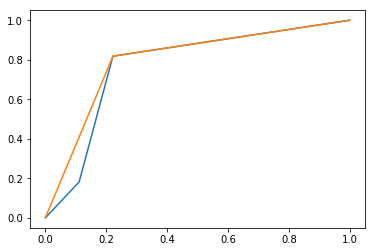

In [3]:
from matplotlib import pyplot as plt
y = [1,1,0,1,1,1,0,1,1,1,1,0,0,0,1,0,1,0,0,0]
#y_p = [(len(y)-x) / len(y) for x in range(len(y))]
y_p = [0.9]*3 + [0.6]*8 + [0.3]*9
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, _ = roc_curve(y,y_p)
plt.plot(fpr,tpr)
print(roc_auc_score(y,y_p))
new_y = [round(x) for x in y_p]
fpr, tpr, _ = roc_curve(y,new_y)
plt.plot(fpr,tpr)
print(roc_auc_score(y,new_y))

In [4]:
y_p

[0.9,
 0.9,
 0.9,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.6,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3,
 0.3]

In [6]:
def ind_y(y1, y2):
    return int(y1 > y2)

def ind_a(a1, a2):
    if a1 == a2:
        return 0.5
    else:
        return int(a1 > a2)

In [7]:
roc_auc = 0
counter = 0
res1 = []
for i in range(len(new_y)):
    for j in range(len(new_y)):
        roc_auc+= ind_y(y[i], y[j]) * ind_a(new_y[i], new_y[j])
        counter+=ind_y(y[i], y[j])
        if (y[i] == 1) & (y[j] == 0) & (ind_a(new_y[i], new_y[j]) > 0):
            res1.append((i,j))
roc_auc/counter

0.797979797979798

In [8]:
roc_auc = 0
counter = 0
res2 = []
for i in range(len(new_y)):
    for j in range(len(y_p)):
        roc_auc+= ind_y(y[i], y[j]) * ind_a(y_p[i], y_p[j])
        counter+=ind_y(y[i], y[j])
        if (y[i] == 1) & (y[j] == 0) & (ind_a(y_p[i], y_p[j]) > 0):
            res2.append((i,j))
roc_auc/counter

0.7727272727272727

In [9]:
set(res1) - set(res2)

{(3, 2), (4, 2), (5, 2), (7, 2), (8, 2), (9, 2), (10, 2)}